In [44]:
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_params['sa']
import numpy as np

In [9]:
hdulist = fits.open('./synchrotron_i_lobe_0700_150MHz.fits')

In [23]:
hdulist.info()

Filename: ./synchrotron_i_lobe_0700_150MHz.fits
No.    Name         Type      Cards   Dimensions   Format
  0  NN_EMISSIVITY_I_LOBE_150.0MHZ  PrimaryHDU      22   (2048, 4096)   float64   


In [49]:
hdu = hdulist['NN_EMISSIVITY_I_LOBE_150.0MHZ']
hdu.header


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 4096                                                  
EXTEND  =                    T                                                  
EXTNAME = 'NN_EMISSIVITY_I_LOBE_150.0MHZ' / extension name                      
BTYPE   = 'nn_emissivity_i_lobe_150.0MHz'                                       
BUNIT   = 'Jy/arcsec**2'                                                        
WCSAXES =                    2                                                  
CRPIX1  =               1024.5                                                  
CRPIX2  =               2048.5                                                  
CDELT1  = 9.42382812499999E+

129.717785809
0.0


/home/ychen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


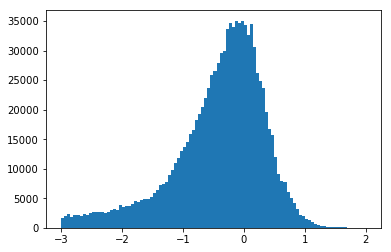

In [40]:
print(hdu.data.max())
print(hdu.data.min())
plt.hist(np.log10(hdu.data.flatten()), range=(-3, 2), bins=100 )
plt.show()

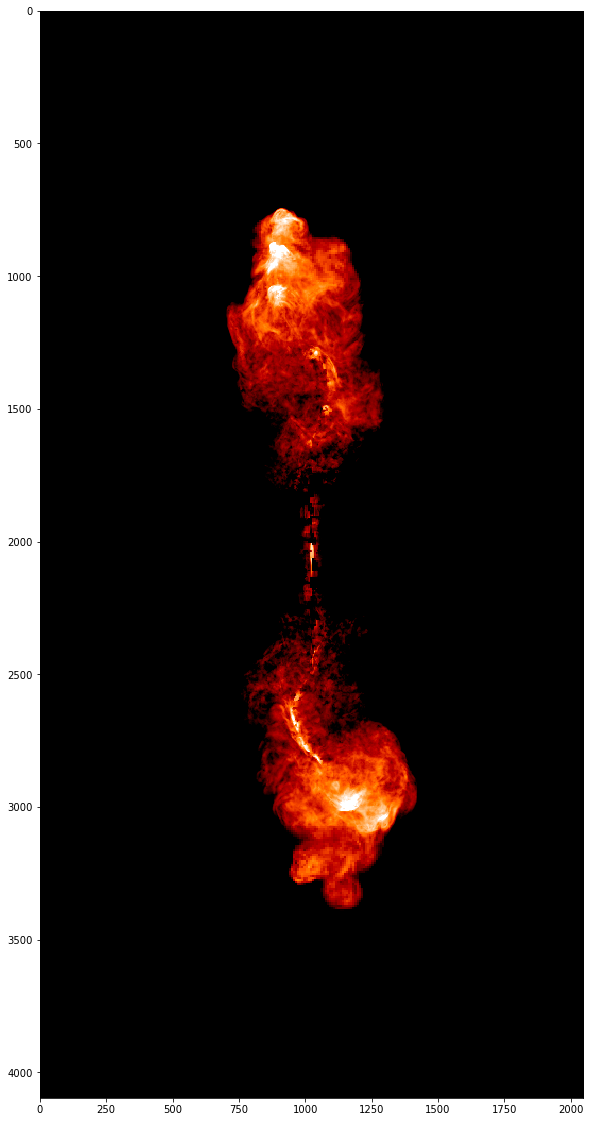

In [48]:
fig = plt.figure(figsize=(10,20))
plt.imshow(np.log10(hdu.data+1e-3), cmap='gist_heat', vmin=-1, vmax=1)

plt.show()